In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/archive.zip archive.zip
!unzip archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: img_txt/1115622578394103808.json  
  inflating: img_txt/1115622867025178625.json  
  inflating: img_txt/1115623108390653952.json  
  inflating: img_txt/1115623403040464896.json  
  inflating: img_txt/1115623527078662144.json  
  inflating: img_txt/1115623679944286208.json  
  inflating: img_txt/1115623877462327296.json  
  inflating: img_txt/1115624172321947648.json  
  inflating: img_txt/1115624287728226304.json  
  inflating: img_txt/1115624298759229440.json  
  inflating: img_txt/1115624435447468034.json  
  inflating: img_txt/1115624443341045760.json  
  inflating: img_txt/1115624455332667392.json  
  inflating: img_txt/1115624636732059648.json  
  inflating: img_txt/1115624779657220096.json  
  inflating: img_txt/1115624948460994561.json  
  inflating: img_txt/1115624967842947072.json  
  inflating: img_txt/1115625034331054080.json  
  inflating: img_txt/1115625409947885568.json  
  inflating: img_txt/1115625459008659

In [4]:
!pip install albumentations==0.4.6
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 15.4 MB/s 
     |████████████████████████████████| 948 kB 78.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=bedef80518300f2b8e920b27c7309e39b8c0bafd5e1392ff4bb4019a8570ba95
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import spacy
import simpletransformers
from simpletransformers.language_representation import RepresentationModel
from scipy import stats
import scipy
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import precision_score,recall_score

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [22]:
df_train = pd.read_csv('splits/train_ids.txt', header = None).reset_index(drop=True)
df_valid = pd.read_csv('splits/val_ids.txt', header = None).reset_index(drop=True)
df_test = pd.read_csv('splits/test_ids.txt', header = None).reset_index(drop=True)

In [8]:
mapping = pd.read_json('MMHS150K_GT.json').T

In [9]:
mapping['id'] = mapping['tweet_url'].apply(lambda x : int(x.split('/')[-1]))
mapping = mapping[mapping['labels'].apply(lambda x: len(x)) == 3]
mapping['tweet_text_cleaned'] = mapping['tweet_text'].map(lambda x: x[: x.find('https')])

In [10]:
def func_lemmatize_text(df, headline = 'tweet_text_cleaned'):
    nlp = spacy.load('en_core_web_sm', disable = ['ner'])
    rows = []
    for index in tqdm(range(len(df))):
        text = df.iloc[index][headline]
        ### Preprocessing text
        text = text.lower()
        text = text.replace('"','').strip()
        tokenized_text = nlp(text)
        lemmatized_text = ' '.join([text.lemma_ for text in tokenized_text])
        rows.append(lemmatized_text)
    df['lemmatized_text'] = rows
    return df

In [11]:
mapping = func_lemmatize_text(mapping)

100%|██████████| 149749/149749 [10:02<00:00, 248.73it/s]


In [12]:
def create_vocab(rows):
    word_dict = defaultdict(int)
    for review in rows:
        tokens = review.split(" ")
        for token in tokens:
            word_dict[token] += 1
    min_freq = 5
    i = 1
    vocab_dict = {}
    for token in word_dict:
        if word_dict[token] > min_freq:
            vocab_dict[token] = i
            i += 1        
    return vocab_dict        

In [13]:
word_dict = create_vocab(list(mapping['lemmatized_text']))

In [14]:
def get_mode_labels(array):
  output = scipy.stats.mode(array, axis = 0)[0][0]
  if output:
    return 1
  else:
    return 0  

In [15]:
mapping['new_labels'] = mapping['labels'].map(lambda x: get_mode_labels(x))

In [16]:
df_train = df_train.merge(mapping, left_on = 0, right_on = 'id', how = 'inner' )[0]
df_valid = df_valid.merge(mapping, left_on = 0, right_on = 'id' )[0]
df_test = df_test.merge(mapping, left_on = 0, right_on = 'id' )[0]

In [17]:
len(df_train)

134754

In [18]:
tweet_length = mapping['lemmatized_text'].map(lambda x: len(x)).values

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


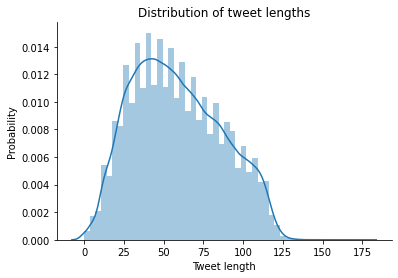

In [19]:
ax = sns.distplot(tweet_length)
ax.set_title('Distribution of tweet lengths')
ax.set_ylabel('Probability')
ax.set_xlabel('Tweet length')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [30]:
class Tweet_dataset(Dataset):
    def __init__(self, df, word_dict, max_length = 160):
        self.df = df
        self.word_dict = word_dict
        self.max_len = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        text = self.df.iloc[idx]['lemmatized_text']
        tokens = text.split(" ")[:self.max_len]
        x = torch.zeros(self.max_len)
        for idx in range(len(tokens)):
            try:
                x[self.max_len - len(tokens) + idx] = self.word_dict[tokens[idx]]
            except:
                x[self.max_len - len(tokens) + idx] = 0 
        y = self.df.iloc[idx]['new_labels']  
        return torch.tensor(x).long().to(device), torch.tensor(y).to(device)

In [23]:
df_train = df_train.merge(mapping, left_on = 0, right_on = 'id')
df_valid = df_valid.merge(mapping, left_on = 0, right_on = 'id' )
df_test = df_test.merge(mapping, left_on = 0, right_on = 'id' )

In [31]:
train_ds = Tweet_dataset(df_train, word_dict)
valid_ds = Tweet_dataset(df_valid, word_dict)
test_ds = Tweet_dataset(df_test, word_dict)

In [32]:
dl_train = DataLoader(train_ds, batch_size = 500, shuffle=True)
dl_valid = DataLoader(valid_ds, batch_size = 200, shuffle=True)
dl_test = DataLoader(test_ds, batch_size = 200, shuffle=True)

In [33]:
df_train['new_labels'].value_counts()

0    114148
1     20606
Name: new_labels, dtype: int64

### Model

In [57]:
class LSTM(nn.Module):
    def __init__(self, dict_size, embedding_size , hidden_size):
        super(LSTM, self).__init__()
        self.emb = nn.Embedding(dict_size, embedding_size, padding_idx = 0)
        self.rnn = nn.LSTM(input_size = embedding_size, 
                           hidden_size = hidden_size, batch_first = True)
        self.linear_layer = nn.Linear(hidden_size , 1)
    def forward(self,x):
        outputs, (hidden, cell) = self.rnn(self.emb(x))
        ### Hidden return the output of the last hidden state 
        x = self.linear_layer(hidden.squeeze())
        return torch.squeeze(x)     

In [58]:
lstm = LSTM(len(word_dict) + 1, 100, 30).to(device)

In [59]:
x, y = next(iter(dl_train))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Train Model

In [60]:
def train_model(model, epochs, train_dl, valid_dl,optimizer, lossFun, print_loss = True):
    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0.0
        for x,y in tqdm(train_dl):
            pos_weight = torch.tensor([5 if el == 1 else 1 for el in y]).to(device)
            y_pred = model(x).float()        
            loss = F.binary_cross_entropy_with_logits(y_pred, y.float(), pos_weight = pos_weight)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print("#"* 80)
        print(f'Epoch {epoch}')
        train_accuracy, train_prscore, train_recall,train_loss = metrics(model, train_dl, len(train_ds)) 
        valid_accuracy, valid_prscore, valid_recall,valid_loss = metrics(model, valid_dl, len(valid_ds)) 
        print(f'train loss : {train_loss} train accuracy:{train_accuracy} train precision:{train_prscore} train recall:{train_recall}')
        print(f'valid loss : {valid_loss} valid accuracy:{valid_accuracy} valid precision:{valid_prscore} valid recall:{valid_recall}')

In [72]:
def metrics(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    y_pred_array = torch.tensor([]).to(device)
    y_array = torch.tensor([]).to(device)
    total_loss = 0
    with torch.no_grad():
      for x, y in tqdm(dataloader):
          y_hat = model(x)
          y_pred = (torch.sigmoid(y_hat) > 0.5).float()
          pos_weight = torch.tensor([5 if el == 1 else 1 for el in y]).to(device)
          loss = F.binary_cross_entropy_with_logits(y_hat, y.float(), pos_weight = pos_weight)
          total_loss += loss.item()
          y_pred_array = torch.cat([y_pred_array,y_pred])
          y_array = torch.cat([y_array,y])
          total_incorrect += torch.count_nonzero(y - y_pred).item()
      avg_loss = total_loss/len(dataloader)    
      percent_wrong = total_incorrect / num_points
      pr_score = precision_score(y_array.cpu(), y_pred_array.cpu())
      re_score = recall_score(y_array.cpu(), y_pred_array.cpu())
    return 1 - percent_wrong,pr_score,re_score,avg_loss

In [62]:
optimizer = optim.Adam(lstm.parameters(), lr = .001)

In [74]:
train_model(lstm, 3, dl_train, dl_valid,optimizer, lossFun, print_loss = True)

  0%|          | 0/270 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 270/270 [01:08<00:00,  3.93it/s]


################################################################################
Epoch 0



100%|██████████| 270/270 [01:05<00:00,  4.14it/s]

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

 33%|███▎      | 1/3 [02:16<04:33, 136.67s/it]

train loss : 0.9577199933705507 train accuracy:0.7367350876411831 train precision:0.7367350876411832 train recall:1.0
valid loss : 0.9374796152114868 valid accuracy:0.7406443866319792 valid precision:0.7406443866319792 valid recall:1.0



  0%|          | 0/270 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 270/270 [01:08<00:00,  3.92it/s]


################################################################################
Epoch 1



100%|██████████| 270/270 [01:06<00:00,  4.08it/s]

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

 67%|██████▋   | 2/3 [04:34<02:17, 137.38s/it]

train loss : 0.882916431956821 train accuracy:0.7367425085711741 train precision:0.7367475825423565 train recall:0.99997985454985
valid loss : 0.9192321276664734 valid accuracy:0.740444266559936 valid precision:0.7405924739791834 valid recall:0.9997298027560119



  0%|          | 0/270 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 270/270 [01:09<00:00,  3.90it/s]


################################################################################
Epoch 2



100%|██████████| 270/270 [01:05<00:00,  4.13it/s]

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 3/3 [06:52<00:00, 137.35s/it]

train loss : 0.8470853885014852 train accuracy:0.736749929501165 train precision:0.7367460223224888 train recall:1.0
valid loss : 0.9750775599479675 valid accuracy:0.740444266559936 valid precision:0.7405924739791834 valid recall:0.9997298027560119
